In [1]:
import matplotlib.pyplot as plt
from IPython.display import display
import numpy as np


Загрузим бандл

In [2]:
project_name = 'gg_project'
dataset_name = 'gg_lenta_big'
bucket = 'ggbucket'


In [3]:
from pathlib import Path
from tg.grammar_ru.common.loc import Loc
from dotenv import load_dotenv
load_dotenv(Loc.root_path / 'environment.env')


True

Создадим бакет

In [4]:
from tg.grammar_ru.ml.components.yandex_storage.s3_yandex_helpers import S3YandexHandler
# S3YandexHandler.create_bucket(bucket)


In [5]:
bundle_folder = Loc.data_cache_path/'bundles/grammatical_gender/big'


In [6]:
from tg.common import DataBundle
from tg.common.ml.batched_training import IndexedDataBundle

# db = DataBundle.load(bundle_folder)
# idb = IndexedDataBundle(db.index, db)
# s = db.src
# len(s.sentence_id.unique()), len(s.word_id.unique())# (479563, 10097148)


In [7]:

import plotly.express as px
# df = px.data.tips()
# fig = px.histogram(s.groupby('sentence_id').word_id.count(), title='Распределение числа слов в предложении')
# fig.show()


In [8]:
s3path = f'datasphere/{project_name}/datasets/{dataset_name}'
# S3YandexHandler.upload_folder(bucket, s3path, bundle_folder)


In [9]:
from tg.common._common import Loc
from tg.grammar_ru.ml.components.yandex_storage.s3_yandex_helpers import S3YandexHandler


### Обучение. Далее - `gg_run_training.py`

In [10]:
from tg.common._common import Loc
from tg.grammar_ru.ml.components.yandex_storage.s3_yandex_helpers import S3YandexHandler
import ast


def get_tasks_list(tasks_list_s3_path, bucket):
    tmp_local_file = Loc.temp_path / tasks_list_s3_path.split('/')[-1]
    S3YandexHandler.download_file(bucket, tasks_list_s3_path, tmp_local_file)
    with open(tmp_local_file, 'r') as f:
        tasks = ast.literal_eval(f.read())


In [11]:
from tg.common._common import Loc
from tg.grammar_ru.ml.components.yandex_storage.s3_yandex_helpers import S3YandexHandler
from tg.grammar_ru.ml.components.yandex_delivery.datasphere_tools import *
import ast
from tg.grammar_ru.ml.components.yandex_delivery.training_logs import S3TrainingLogsLoader, TrainingLogsViewer
from typing import List


In [12]:
tasks = get_tasks_list('datasphere/gg_project/job_info/job_gg_project_11:38:18.460849.txt',
                       bucket)

loader = S3TrainingLogsLoader(bucket, project_name)
metrics = loader.load_metrics(tasks)
# metrics


/home/serhio/grammar_ru/temp/training_results/gg_task 11:38:18.460985.tar.gz
output/
output/batcher.pkl
output/history.pkl
output/info.pkl
output/metrics.pkl
output/model.pkl
output/result_df.parquet
output/test_splits.pkl
output/train_split.pkl
output/training_task.pkl


In [13]:
TrainingLogsViewer.get_metric_by_job(metrics, 'accuracy_display')


job_id,gg_task 11:38:18.460985
0,0.380557
1,0.380557


####  debug net

In [14]:
import matplotlib.pyplot as plt
# plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'accuracy_display'))


In [15]:
from tg.common import DataBundle
from tg.common.ml.batched_training import IndexedDataBundle

from tg.common.ml import batched_training as bt
from tg.common.ml.batched_training import torch as btt
from tg.common.ml.batched_training import context as btc
from tg.common.ml import dft
from yo_fluq_ds import fluq


from tg.grammar_ru.ml.components.attention_network import AttentionNetwork
from tg.common.ml.batched_training.torch.networks.lstm_network import LSTMFinalizer

from tg.grammar_ru.ml.components.extractor_settings import CoreExtractor
from tg.grammar_ru.ml.components.plain_context_builder import PlainContextBuilder
import datetime
from tg.grammar_ru.ml.components.training_task_factory import TaskFactory
from tg.grammar_ru.ml.components.training_task_factory import Conventions
from tg.common.ml.training_core import TrainingEnvironment
from tg.grammar_ru.ml.components.contextual_binding import ContextualBinding, ContextualNetworkType

from tg.grammar_ru.ml.components.yandex_delivery.training_job import TrainingJob
from tg.grammar_ru.ml.components.yandex_storage.s3_yandex_helpers import S3YandexHandler
from tg.common.delivery.jobs import SSHDockerJobRoutine, DockerOptions
from tg.common.delivery.packaging import FakeContainerHandler

from tg.grammar_ru.common import Loc
from sklearn.metrics import roc_auc_score
from typing import Dict, Optional  # TODO delete redundant
from tg.common.delivery.training.architecture import FileCacheTrainingEnvironment
from tg.grammar_ru.ml.components.yandex_delivery.docker_tools import deploy_container
from tg.common.delivery.jobs.ssh_docker_job_routine import build_container
from tg.common.ml.batched_training.torch.networks import FeedForwardNetwork, FullyConnectedNetwork
import torch
from pathlib import Path
from dotenv import load_dotenv

from tg.grammar_ru.common import Loc

load_dotenv(Loc.root_path / 'environment.env')

project_name = 'gg_project'
dataset_name = 'gg_dataset'
bucket = 'ggbucket'


class MulticlassMetrics(bt.Metric):
    def __init__(self, add_accuracy=True, add_rating=False):
        self.add_accuracy = add_accuracy
        self.add_rating = add_rating

    def get_names(self):
        result = []
        if self.add_accuracy:
            result.append('accuracy')
        if self.add_rating:
            result.append('rating')
        return result

    def measure(self, df, _):
        prefix = 'true_label_'
        labels = []
        for c in df.columns:
            if c.startswith(prefix):
                labels.append(c.replace(prefix, ''))

        def ustack(df, prefix, cols, name):
            df = df[[prefix+c for c in cols]]
            df.columns = [c for c in cols]
            df = df.unstack().to_frame(name)
            return df

        predicted = ustack(df, 'predicted_label_', labels, 'predicted')
        true = ustack(df, 'true_label_', labels, 'true')
        df = predicted.merge(true, left_index=True,
                             right_index=True).reset_index()
        df.columns = ['label', 'sample', 'predicted', 'true']
        df = df.feed(fluq.add_ordering_column(
            'sample', ('predicted', False), 'predicted_rating'))

        match = (df.loc[df.predicted_rating ==
                 0].set_index('sample').true > 0.5)
        rating = df.loc[df.true > 0.5].set_index('sample').predicted_rating
        result = []
        if self.add_accuracy:
            result.append(match.mean())
        if self.add_rating:
            result.append(rating.mean())
        return result


def get_multilabel_extractor():
    label_extractor = (bt.PlainExtractor
                       .build(Conventions.LabelFrame)
                       .index()
                       .apply(take_columns=['label'], transformer=dft.DataFrameTransformerFactory.default_factory())
                       )
    return label_extractor


class MyNetworkFactory:
    def __init__(self, nn_head_factory):
        self.nn_head_factory = nn_head_factory

    def create_network(self, task, input):  # input is batch ~ sample
        nn_head = self.nn_head_factory.create_network(task=None, input=input)
        head_out = nn_head(input)
        hidden_size = head_out.shape[1]
        labels_count = input['label'].shape[1]
        nn_tail = FullyConnectedNetwork(
            sizes=[], input=hidden_size, output=labels_count)
        # return FeedForwardNetwork(nn_head, nn_tail, torch.nn.Softmax(dim=1))
        return FeedForwardNetwork(nn_head, nn_tail)


class ClassificationTask(TaskFactory):
    def get_network(self, _, sample):
        assembled_network_factory = MyNetworkFactory(self.nn_head_factory)
        assembled_network = assembled_network_factory.create_network(
            task=None, input=sample)
        return assembled_network

    def create_task(
        self, data: IndexedDataBundle,
            env: Optional[TrainingEnvironment] = None) -> None:

        metrics = bt.MetricPool().add(MulticlassMetrics())
        self.instantiate_default_task(
            epoch_count=2,
            batch_size=100,
            mini_batch_size=50,
            mini_epoch_count=1,
            metric_pool=metrics
        )

        plain_context_builder = PlainContextBuilder(include_zero_offset=False,
                                                    left_to_right_contexts_proportion=1)

        plain_context = ContextualBinding(
            name='plain_context',
            context_length=3,
            network_type=ContextualNetworkType.Plain,
            hidden_size=[30],
            context_builder=plain_context_builder,
            extractor=CoreExtractor(join_column='another_word_id'),
            debug=False
        )
        self.nn_head_factory = plain_context.create_network_factory(
            task=None, input=None)  # TODO could be better?
        core_extractor = plain_context.create_extractor(task=None, bundle=data)
        self.setup_batcher(data, [core_extractor, get_multilabel_extractor()])
        self.setup_model(self.get_network)


def get_training_job() -> TrainingJob:
    task = ClassificationTask()
    task.info["dataset"] = dataset_name
    task.info["name"] = "gg_task"

    job = TrainingJob(
        tasks=[task],
        project_name=project_name,
        bucket=bucket
    )
    return job


job = get_training_job()

routine = SSHDockerJobRoutine(
    job=job,
    remote_host_address=None,
    remote_host_user=None,
    handler_factory=FakeContainerHandler.Factory(),
    options=DockerOptions(propagate_environmental_variables=["AWS_ACCESS_KEY_ID",
                                                             "AWS_SECRET_ACCESS_KEY"])
)
# tag = 'v_' + datetime.datetime.now().time().strftime("%H_%M_%S")
# dockerhub_repo = 'grammar_repo'  # name of your repo
# dockerhub_login = 'sergio0x0'  # your login

# local_img = 'gg_img'


# job.run()
# b_path = Loc.bundles_path/'grammatical_gender/toy'
# data = DataBundle.load(b_path)

# task = ClassificationTask()
# task.create_task(data)
# temp_batch = task.task.generate_sample_batch(data, 0)


In [16]:
# net = task.task.model_handler.network


In [17]:
# net(temp_batch)


In [18]:
# net


#### build bundle.py error on Full lenta 

cat nohup.out | tail -n 5

2022-12-15 21:42:14.310782+00:00 INFO: Processed 48077323 words. 251/869
2022-12-15 21:42:46.130967+00:00 INFO: Writing 2 frames, 35747735 words, to write 49992, to keep 35697743
2022-12-15 21:42:47.162703+00:00 INFO: Processed 48294463 words. 252/869
2022-12-15 21:43:15.324902+00:00 INFO: Writing 2 frames, 35847701 words, to write 49979, to keep 35797722
2022-12-15 21:43:17.499093+00:00 INFO: Processed 48444421 words. 253/869

Собрал бандл из 200 файлов

### EDA

In [19]:
db = DataBundle.load(Loc.data_cache_path/'bundles/grammatical_gender/toy')
idb = IndexedDataBundle(db.index, db)
s = db.src


#### Размеры датасетов

(249907, 2499299, 10097148)

In [20]:
# (DataBundle.load(Loc.data_cache_path/'bundles/grammatical_gender/toy').src.shape[0],
# DataBundle.load(Loc.data_cache_path/'bundles/grammatical_gender/big').src.shape[0],
# DataBundle.load(Loc.data_cache_path/'bundles/grammatical_gender/full').src.shape[0])


In [21]:
s.shape[0]


249907

In [22]:
import pandas as pd
# pd.value_counts()


In [23]:
s.label.value_counts(normalize=True)  # toy


-1    0.442000
 0    0.227096
 1    0.143353
 3    0.094583
 2    0.092967
Name: label, dtype: float64

In [24]:
s[s.label == 3].word.head(30)


25          которых
26        оказались
38          финских
46        проживает
56         сообщает
60      задержанные
61        оказались
62       хоккейными
65          которые
66        распивали
67      алкогольные
70     общественных
78       доставляли
81      подвыпившие
86        карманные
94        мобильных
107      британских
108     Королевских
109             ВВС
111        передает
135           какие
145          данным
153         оцепили
154      британские
177       иракскими
197           Винчи
200      сообщается
226      оскорбляет
227        верующих
231       извращает
Name: word, dtype: object

## Результаты обучения

In [25]:
tasks = get_tasks_list('datasphere/gg_project/job_info/job_gg_project_11:43:02.110706.txt',
                       bucket)

loader = S3TrainingLogsLoader(bucket, project_name)
metrics = loader.load_metrics(tasks)
metrics


/home/serhio/grammar_ru/temp/training_results/gg_task_lenta_big_10K_4ep 11:43:02.110772.tar.gz
output/
output/batcher.pkl
output/history.pkl
output/info.pkl
output/metrics.pkl
output/model.pkl
output/result_df.parquet
output/test_splits.pkl
output/train_split.pkl
output/training_task.pkl


,metric,ordinal,value,timestamp,job_id
0,accuracy_test,0,0.495043,2022-12-16 11:54:16.340953,gg_task_lenta_big_10K_4ep 11:43:02.110772
1,accuracy_display,0,0.493511,2022-12-16 11:54:16.340953,gg_task_lenta_big_10K_4ep 11:43:02.110772
2,loss,0,0.166821,2022-12-16 11:54:16.340953,gg_task_lenta_big_10K_4ep 11:43:02.110772
3,iteration,0,0.000000,2022-12-16 11:54:16.340953,gg_task_lenta_big_10K_4ep 11:43:02.110772
4,accuracy_test,1,0.504205,2022-12-16 12:03:00.036073,gg_task_lenta_big_10K_4ep 11:43:02.110772
5,accuracy_display,1,0.502487,2022-12-16 12:03:00.036073,gg_task_lenta_big_10K_4ep 11:43:02.110772
6,loss,1,0.157089,2022-12-16 12:03:00.036073,gg_task_lenta_big_10K_4ep 11:43:02.110772
7,iteration,1,1.000000,2022-12-16 12:03:00.036073,gg_task_lenta_big_10K_4ep 11:43:02.110772
8,accuracy_test,2,0.508279,2022-12-16 12:11:45.625511,gg_task_lenta_big_10K_4ep 11:43:02.110772
9,accuracy_display,2,0.507149,2022-12-16 12:11:45.625511,gg_task_lenta_big_10K_4ep 11:43:02.110772


In [26]:
TrainingLogsViewer.get_metric_by_job(metrics, 'accuracy_display')


job_id,gg_task_lenta_big_10K_4ep 11:43:02.110772
0,0.493511
1,0.502487
2,0.507149
3,0.511105


In [27]:
TrainingLogsViewer.get_metric_by_job(metrics, 'accuracy_test')


job_id,gg_task_lenta_big_10K_4ep 11:43:02.110772
0,0.495043
1,0.504205
2,0.508279
3,0.512254


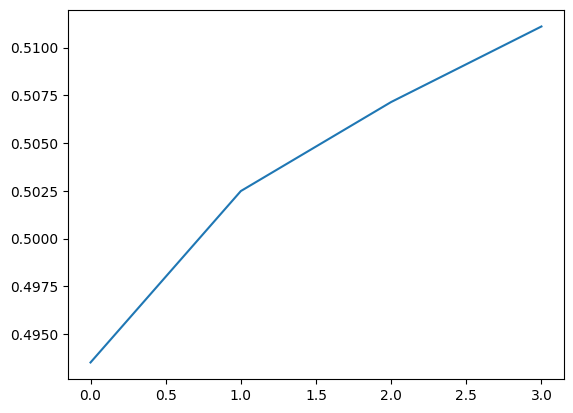

In [28]:
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'accuracy_display'))


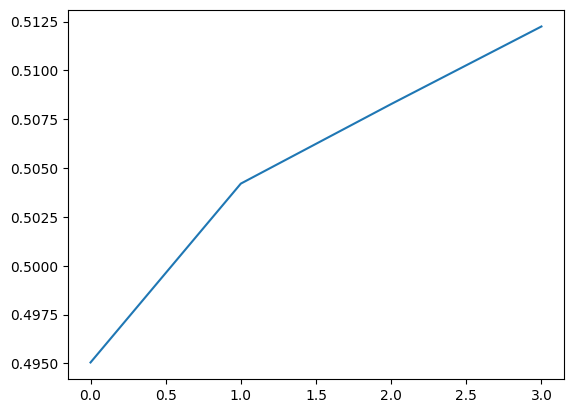

In [29]:
plt.plot(TrainingLogsViewer.get_metric_by_job(metrics, 'accuracy_test'))


### LENTA big 100 epochs bs=20K 14 hours

In [30]:
tasks = get_tasks_list('datasphere/gg_project/job_info/job_gg_project_14:33:31.516733.txt',
                       bucket)

loader = S3TrainingLogsLoader(bucket, project_name)
metrics = loader.load_metrics(tasks)
metrics


/home/serhio/grammar_ru/temp/training_results/gg_task_lenta_big_20K_100ep 14:33:31.516791.tar.gz
output/
output/batcher.pkl
output/history.pkl
output/info.pkl
output/metrics.pkl
output/model.pkl
output/result_df.parquet
output/test_splits.pkl
output/train_split.pkl
output/training_task.pkl


,metric,ordinal,value,timestamp,job_id
0,accuracy_test,0,0.495166,2022-12-16 14:42:00.033465,gg_task_lenta_big_20K_100ep 14:33:31.516791
1,accuracy_display,0,0.493470,2022-12-16 14:42:00.033465,gg_task_lenta_big_20K_100ep 14:33:31.516791
2,loss,0,0.167273,2022-12-16 14:42:00.033465,gg_task_lenta_big_20K_100ep 14:33:31.516791
3,iteration,0,0.000000,2022-12-16 14:42:00.033465,gg_task_lenta_big_20K_100ep 14:33:31.516791
4,accuracy_test,1,0.504062,2022-12-16 14:49:51.747824,gg_task_lenta_big_20K_100ep 14:33:31.516791
...,...,...,...,...,...
395,iteration,98,98.000000,2022-12-17 03:44:36.163694,gg_task_lenta_big_20K_100ep 14:33:31.516791
396,accuracy_test,99,0.562257,2022-12-17 03:52:39.796546,gg_task_lenta_big_20K_100ep 14:33:31.516791
397,accuracy_display,99,0.564427,2022-12-17 03:52:39.796546,gg_task_lenta_big_20K_100ep 14:33:31.516791
398,loss,99,0.136952,2022-12-17 03:52:39.796546,gg_task_lenta_big_20K_100ep 14:33:31.516791


In [31]:
metrics.tail(4)


,metric,ordinal,value,timestamp,job_id
396,accuracy_test,99,0.562257,2022-12-17 03:52:39.796546,gg_task_lenta_big_20K_100ep 14:33:31.516791
397,accuracy_display,99,0.564427,2022-12-17 03:52:39.796546,gg_task_lenta_big_20K_100ep 14:33:31.516791
398,loss,99,0.136952,2022-12-17 03:52:39.796546,gg_task_lenta_big_20K_100ep 14:33:31.516791
399,iteration,99,99.000000,2022-12-17 03:52:39.796546,gg_task_lenta_big_20K_100ep 14:33:31.516791


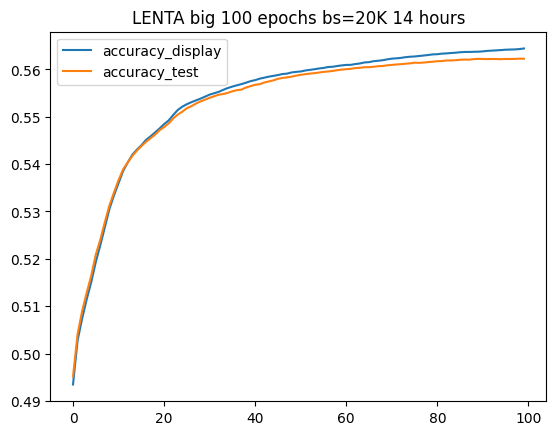

In [32]:
plt.plot(TrainingLogsViewer.get_metric_by_job(
    metrics, 'accuracy_display'), label='accuracy_display')
plt.plot(TrainingLogsViewer.get_metric_by_job(
    metrics, 'accuracy_test'), label='accuracy_test')
plt.title('LENTA big 100 epochs bs=20K 14 hours')
plt.legend()


# lenta big 20K 200ep

In [33]:
tasks = get_tasks_list('datasphere/gg_project/job_info/job_gg_project_20:44:19.636574.txt',
                       bucket)
lenta_big_20k_200ep_task = tasks[0]

loader = S3TrainingLogsLoader(bucket, project_name)
metrics = loader.load_metrics(tasks)
metrics


/home/serhio/grammar_ru/temp/training_results/task_gg_lenta_big_20K_200ep 20:44:19.636646.tar.gz
output/
output/batcher.pkl
output/history.pkl
output/info.pkl
output/metrics.pkl
output/model.pkl
output/result_df.parquet
output/test_splits.pkl
output/train_split.pkl
output/training_task.pkl


,metric,ordinal,value,timestamp,job_id
0,accuracy_test,0,0.494714,2022-12-17 20:53:14.548988,task_gg_lenta_big_20K_200ep 20:44:19.636646
1,accuracy_display,0,0.493064,2022-12-17 20:53:14.548988,task_gg_lenta_big_20K_200ep 20:44:19.636646
2,loss,0,0.166835,2022-12-17 20:53:14.548988,task_gg_lenta_big_20K_200ep 20:44:19.636646
3,iteration,0,0.000000,2022-12-17 20:53:14.548988,task_gg_lenta_big_20K_200ep 20:44:19.636646
4,accuracy_test,1,0.504258,2022-12-17 21:01:29.849502,task_gg_lenta_big_20K_200ep 20:44:19.636646
...,...,...,...,...,...
795,iteration,198,198.000000,2022-12-19 00:50:37.486178,task_gg_lenta_big_20K_200ep 20:44:19.636646
796,accuracy_test,199,0.563909,2022-12-19 00:59:11.049299,task_gg_lenta_big_20K_200ep 20:44:19.636646
797,accuracy_display,199,0.566207,2022-12-19 00:59:11.049299,task_gg_lenta_big_20K_200ep 20:44:19.636646
798,loss,199,0.135980,2022-12-19 00:59:11.049299,task_gg_lenta_big_20K_200ep 20:44:19.636646


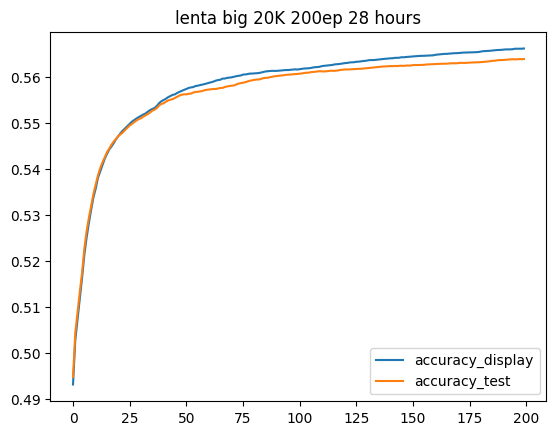

In [34]:
plt.plot(TrainingLogsViewer.get_metric_by_job(
    metrics, 'accuracy_display'), label='accuracy_display')
plt.plot(TrainingLogsViewer.get_metric_by_job(
    metrics, 'accuracy_test'), label='accuracy_test')
plt.title('lenta big 20K 200ep 28 hours')
plt.legend()


# lenta full 20k 50ep

In [35]:
tasks = get_tasks_list('datasphere/gg_project/job_info/job_gg_project_20:37:06.663167.txt',
                       bucket)

loader = S3TrainingLogsLoader(bucket, project_name)
metrics = loader.load_metrics(tasks)
# metrics


/home/serhio/grammar_ru/temp/training_results/task_gg_lenta_full_20K_50ep 20:37:06.663242.tar.gz
output/
output/batcher.pkl
output/history.pkl
output/info.pkl
output/metrics.pkl
output/model.pkl
output/result_df.parquet
output/test_splits.pkl
output/train_split.pkl
output/training_task.pkl


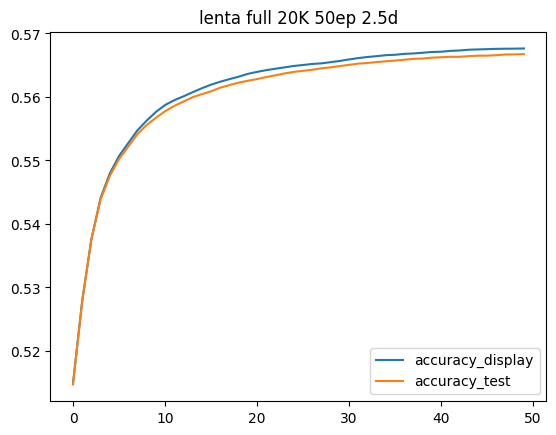

In [36]:
plt.plot(TrainingLogsViewer.get_metric_by_job(
    metrics, 'accuracy_display'), label='accuracy_display')
plt.plot(TrainingLogsViewer.get_metric_by_job(
    metrics, 'accuracy_test'), label='accuracy_test')
plt.title('lenta full 20K 50ep 2.5d')
plt.legend()


# Подбор bs

In [51]:
# tasks = get_tasks_list('datasphere/gg_project/job_info/job_gg_project_13:14:46.600490.txt',
#                        bucket)

# loader = S3TrainingLogsLoader(bucket, project_name)
# metrics = loader.load_metrics(tasks)
# display(metrics)


# Результаты обучения lenta big 20K 200ep

In [39]:
Loc.root_path


PosixPath('/home/serhio/grammar_ru')

In [40]:
lenta_big_20k_200ep_task


'task_gg_lenta_big_20K_200ep 20:44:19.636646'

### result_df

In [111]:
unzipped_folder = (Loc.root_path /
                   'temp'/'training_results' /
                   f'{lenta_big_20k_200ep_task}.unzipped')
result_df = pd.read_parquet(unzipped_folder/'output'/'result_df.parquet')
result_df


,word_id,sentence_id,label,split,true_label_0,predicted_label_0,true_label_1,predicted_label_1,true_label_3,predicted_label_3,true_label_2,predicted_label_2,stage
sample_id,,,,,,,,,,,,,
1,1,0,0,test,1.0,0.235964,0.0,0.103293,0.0,0.020730,0.0,0.697159,test
2,2,0,2,test,0.0,0.275742,0.0,0.207088,0.0,0.414074,1.0,0.106180,test
3,4,0,0,test,1.0,0.689275,0.0,0.055883,0.0,0.073416,0.0,0.037342,test
4,5,0,0,test,1.0,0.365668,0.0,0.202043,0.0,0.027792,0.0,0.453792,test
6,7,0,0,test,1.0,0.332759,0.0,0.310349,0.0,0.036474,0.0,0.286194,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377780,2499413,2332125,1,display,0.0,0.017303,1.0,0.931538,0.0,0.138549,0.0,0.007848,display
1377783,2499417,2332125,0,display,1.0,0.415809,0.0,0.218996,0.0,0.044620,0.0,0.306053,display
1377786,2499421,2332125,1,display,0.0,0.173255,1.0,0.703678,0.0,0.004112,0.0,0.145358,display


In [112]:
predicted_probs = result_df[[
    'predicted_label_0', 'predicted_label_1', 'predicted_label_2', 'predicted_label_3']]
y_pred = pd.Series(np.argmax(predicted_probs.values,
                   axis=1), index=result_df.index)


In [113]:
true_probs = result_df[[
    'true_label_0', 'true_label_1', 'true_label_2', 'true_label_3']]
y_true = pd.Series(np.argmax(true_probs.values, axis=1), index=result_df.index)


### Confusion matrix

In [114]:
from sklearn.metrics import confusion_matrix

By definition a confusion matrix C is such that `C[i][j]` is equal to the number of observations known to be in group `i` and predicted to be in group `j`.

In [115]:
genders = ['male', 'female', 'mid', 'none']


In [116]:
pd.DataFrame(confusion_matrix(y_true, y_pred, normalize='true'),
             columns=[f'pred_as_{g}' for g in genders],
             index=[f'actual_is_{g}' for g in genders])


,pred_as_male,pred_as_female,pred_as_mid,pred_as_none
actual_is_male,0.766237,0.048390,0.071210,0.114162
actual_is_female,0.535840,0.293901,0.071301,0.098958
actual_is_mid,0.494566,0.060977,0.334643,0.109814
actual_is_none,0.226419,0.025061,0.028406,0.720114


### Выводы:

* Модель склоняется к тому, чтобы все называть мужским родом.
* Неприятное поведение: для половины слов женского рода, ответ модели - мужской род. Для среднего рода так же.

In [117]:
result_df

,word_id,sentence_id,label,split,true_label_0,predicted_label_0,true_label_1,predicted_label_1,true_label_3,predicted_label_3,true_label_2,predicted_label_2,stage
sample_id,,,,,,,,,,,,,
1,1,0,0,test,1.0,0.235964,0.0,0.103293,0.0,0.020730,0.0,0.697159,test
2,2,0,2,test,0.0,0.275742,0.0,0.207088,0.0,0.414074,1.0,0.106180,test
3,4,0,0,test,1.0,0.689275,0.0,0.055883,0.0,0.073416,0.0,0.037342,test
4,5,0,0,test,1.0,0.365668,0.0,0.202043,0.0,0.027792,0.0,0.453792,test
6,7,0,0,test,1.0,0.332759,0.0,0.310349,0.0,0.036474,0.0,0.286194,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377780,2499413,2332125,1,display,0.0,0.017303,1.0,0.931538,0.0,0.138549,0.0,0.007848,display
1377783,2499417,2332125,0,display,1.0,0.415809,0.0,0.218996,0.0,0.044620,0.0,0.306053,display
1377786,2499421,2332125,1,display,0.0,0.173255,1.0,0.703678,0.0,0.004112,0.0,0.145358,display


In [151]:
b_path = Loc.bundles_path/'grammatical_gender/big'
bundle = DataBundle.load(b_path)
src = bundle.src

In [141]:
from yo_fluq_ds import FileIO
from tg.common.delivery.training.architecture import ResultPickleReader

# rs = ResultPickleReader(unzipped_folder)
# x = pd.DataFrame(FileIO.read_pickle(
# rs.get_path('output/train_split.pkl')))
# x


### Худшие предсказания модели

In [142]:
len(bundle.index)

1377791

### male instead of female

In [143]:
result_df['pred_label'] = y_pred
result_df

,word_id,sentence_id,label,split,true_label_0,predicted_label_0,true_label_1,predicted_label_1,true_label_3,predicted_label_3,true_label_2,predicted_label_2,stage,pred_label
sample_id,,,,,,,,,,,,,,
1,1,0,0,test,1.0,0.235964,0.0,0.103293,0.0,0.020730,0.0,0.697159,test,2
2,2,0,2,test,0.0,0.275742,0.0,0.207088,0.0,0.414074,1.0,0.106180,test,3
3,4,0,0,test,1.0,0.689275,0.0,0.055883,0.0,0.073416,0.0,0.037342,test,0
4,5,0,0,test,1.0,0.365668,0.0,0.202043,0.0,0.027792,0.0,0.453792,test,2
6,7,0,0,test,1.0,0.332759,0.0,0.310349,0.0,0.036474,0.0,0.286194,test,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1377780,2499413,2332125,1,display,0.0,0.017303,1.0,0.931538,0.0,0.138549,0.0,0.007848,display,1
1377783,2499417,2332125,0,display,1.0,0.415809,0.0,0.218996,0.0,0.044620,0.0,0.306053,display,0
1377786,2499421,2332125,1,display,0.0,0.173255,1.0,0.703678,0.0,0.004112,0.0,0.145358,display,1


In [147]:
male_inst_female = result_df[(result_df.true_label_1 == 1) & (result_df.pred_label == 0)]
worst_mistakes_scores = male_inst_female.predicted_label_0.sort_values(ascending=False).head(10)
worst_mistakes_scores

sample_id
424751     0.987921
470115     0.986439
695755     0.985778
239016     0.985289
4158       0.984722
965941     0.984326
60016      0.983088
1208968    0.982783
1231968    0.982171
1194186    0.982152
Name: predicted_label_0, dtype: float64

In [154]:
worst_words = bundle.src.loc[worst_mistakes_scores.index][['word_id','sentence_id','word']]
worst_sents = worst_words['sentence_id'].unique()
worst_sents_df = src[src.sentence_id.isin(worst_sents)]

In [170]:
from tg.grammar_ru.common import Separator

Separator.Viewer().tooltip("word_id").color('word_id',
                                            value_to_color={
                                                wid: 'red' for wid in worst_words.word_id}
                                            ).to_html_display(worst_sents_df)
